In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import astropy.io as ascii
from astropy.io import fits
from scipy.optimize import curve_fit
import os
import nkrpy
from importlib import reload
from nkrpy import atomiclines
from nkrpy import constants
from nkrpy.functions import *
fun = reload(nkrpy.functions)
atomiclines = reload(nkrpy.atomiclines)
listoflines = atomiclines.call(wtype='nir',bu='microns').aperture().return_lines()

# Pretty Plotting

In [2]:
def plotting(ax,xmin,xmax,x,y,tempsource,line,count,fitfn=None,start=False):
    colours = ['orange','black','blue','green','purple']
    colour = colours[count%len(colours)]
    y = np.array(y)
    x = np.array(x)
    origx = x.copy()
    origy = y.copy()
    x = x[~np.isnan(origy)]
    y = y[~np.isnan(origy)]
     
    if start == False:
        temp = []
        if count == 0:
            for i,j in enumerate(x):
                if (j < 1.95) or (j > 2.4):
                    temp.append(i)
        elif count == 1:
            for i,j in enumerate(x):
                if ((1.8 < j) or (j < 1.5)):
                    temp.append(i)
        elif count == 2:
            for i,j in enumerate(x):
                if (1.33 < j) or (j < 1.17):
                    temp.append(i)
        elif count == 3:
            for i,j in enumerate(x):
                if (1.02<j): 
                    temp.append(i)
        elif count == 4:
            for i,j in enumerate(x):
                if (j < 0.95):
                    temp.append(i)
        if fitfn:
            for i in temp:
                y[i] = fitfn(x[i])
            y = y/fitfn(x)

    ax.plot(x,y,'-',color=colour,label=tempsource[-6:])
    #ax.plot(x,linear(x,*params),label='Flatten')
    for f in line:
        #print(f)
        naming = f
        for pl,pj in enumerate(line[f]):
            val = find_nearest(x,pj)[0]
            if (min(x) <= pj <= max(x) ):
                kernel = 30
                if kernel<=val<len(x)-kernel -1:
                    region=y[val-10:val+10] 
                elif val > 0:
                    region=y[val:val+kernel]
                elif val<len(x)-1:
                    region=y[val-kernel:val]
                else:
                    region = y[val]
                try:
                    linepos = max(region)
                except ValueError:
                    linepos = 2*np.nanmean(y)
                ax.text(pj, linepos*1.05, naming,
                    verticalalignment='bottom',
                    horizontalalignment='center',
                    fontsize=15, color='red',rotation='vertical')

                ax.plot((pj,pj),(linepos,linepos*1.05),'r-')
    return x,y

In [3]:
def formatter(ax1,ax2=None,xlim='',xlabel='',ylabel='',d=0.015):
    if ax1 and ax2:
        xmin1,xmax1,xmin2,xmax2 = [float(x) for x in xlim.split(',')]
        ax1.set_xlim(xmin1,xmax1)
        ax2.set_xlim(xmin2,xmax2)
        
        ax1.spines['right'].set_visible(False)
        ax2.spines['left'].set_visible(False)
        ax1.tick_params(labelright='off')
        ax2.yaxis.tick_right()
        ax1.set_ylabel(ylabel)
        label = ax1.set_xlabel(xlabel)
        ax1.xaxis.set_label_coords(1., -0.05)
        # d= how big to make the diagonal lines in axes coordinates
        # arguments to pass plot, just so we don't keep repeating them
        kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
        ax1.plot((1-d,1+d), (-d,+d), **kwargs)
        ax1.plot((1-d,1+d),(1-d,1+d), **kwargs)
        ax2.plot((xmin2,xmin2),(-100,100),color='black',linewidth=5)

        kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
        ax2.plot((-d,+d), (1-d,1+d), **kwargs)
        ax2.plot((-d,+d), (-d,+d), **kwargs)

        plt.subplots_adjust(wspace=0, hspace=0)
        ax1.legend()
        ax2.legend()
    else:
        plt.subplots_adjust(wspace=0, hspace=0)
        ax1.legend()

In [4]:
def fft(lam,flux):
    F        = np.fft.rfft(flux)
    #F         = np.fft.fftshift( F1 )
    ps        = np.abs(F)**2
    amps      = np.abs(F)
    wave_step = np.abs(lam[0] - lam[-1])/len(lam)
    wavenum   = np.fft.rfftfreq(flux.size, wave_step)
    idx       = np.argsort(wavenum)

    return wavenum[idx],lam[idx], amps[idx], ps[idx],F[idx]

def cut_fft(time,signal,cut,inverse=False):
    W = np.fft.rfftfreq(signal.size, d=np.abs(time[-1]-time[0])/len(time))
    f_signal = np.fft.rfft(signal)     

    # If our original signal time was in seconds, this is now in Hz    
    cut_f_signal = f_signal.copy()
    if not inverse:
        cut_f_signal[np.where(W<cut)] = 0
    else:
        cut_f_signal[np.where(W>cut)] = 0
    cutsig = np.fft.irfft(cut_f_signal)
    #print(W.shape,f_signal.shape,cutsig.shape)
    if cutsig.shape > time.shape:
        re = time.shape[0]
        cutsig = cutsig[:re]
    elif cutsig.shape < time.shape:
        re = cutsig.shape[0]
        #print(re)
        time = time[:re]
    
    return time,np.abs(cutsig)

In [5]:
source = 'HOPS-370'
listoffiles='HOPS-370.2.tellcor.fits'
dire = 'combined'
count = 0
start=True
orderlim=7
xmin1=0.95
xmax1=2.0
xmin2=1.95
xmax2=2.5
ymin = 0
ymax = 2.E-14

In [6]:
os.system('mkdir ' + dire)
# make sure you add statement for naming
f,(ax1,ax2) = plt.subplots(1,2,figsize=[16,9],sharey=True,facecolor='w')
plt.text(1., 1.02, source,
         horizontalalignment='center',
         fontsize=20,
         transform = ax1.transAxes)
hdulist = fits.open(listoffiles)
print(hdulist[0].data.shape)
for j in range(len(hdulist[0].data[:,0,:])):   
    if j != orderlim:
        lam = hdulist[0].data[j,0,:]
        flux = hdulist[0].data[j,1,:]
        if j > 0:
            plotting(ax1,xmin1,xmax1,lam,flux,source+"_order"+str(j+3),\
                     line=listoflines,count=j,start=start)
        else:
            plotting(ax2,xmin2,xmax2,lam,flux,source+"_order"+str(j+3),\
                     line=listoflines,count=j,start=start)
    count +=1
    
ax2.plot((xmin2,xmin2),(-100,100),color='black')
           
formatter(ax1,ax2,xlim="{},{},{},{}".format(xmin1,xmax1,xmin2,xmax2),\
          xlabel=r'Lambda ($\mu$m)',\
          ylabel=r"Flux (ergs s$^{-1}$ cm$^{-2}$ A$^{-1}$)")
plt.ylim(ymin,ymax)
plt.draw()
plt.savefig(dire+'/'+source+'_combined.pdf',dpi=100)
plt.close()

(3, 3, 2048)


In [7]:
f,(ax1,ax2) = plt.subplots(1,2,sharey=True, figsize=[16,12],facecolor='w')
plt.text(1., 1.02, source,
         horizontalalignment='center',
         fontsize=20,
         transform = ax1.transAxes)
raw={}
start=True
hdulist = fits.open(listoffiles)
for j in range(len(hdulist[0].data[:,0,:])):   
    lam = hdulist[0].data[j,0,:]
    flux = hdulist[0].data[j,1,:]
    temp = '{}o'.format(j)
    raw[temp] = [lam,flux]
    if j > 0:
        plotting(ax1,xmin1,xmax1,lam,flux,\
                source+"_order"+str(j+3),listoflines,count=j,start=start)
    else:
        plotting(ax2,xmin2,xmax2,lam,flux,\
                source+"_order"+str(j+3),listoflines,count=j,start=start)            

ax2.plot((xmin2,xmin2),(-100,100),color='black')
formatter(ax1,ax2,xlim="{},{},{},{}".format(xmin1,xmax1,xmin2,xmax2),\
          xlabel=r'Lambda ($\mu$m)',\
          ylabel=r"Flux (ergs s$^{-1}$ cm$^{-2}$ A$^{-1}$)")
plt.ylim(ymin,ymax)
plt.draw()
plt.savefig(dire+'/'+source+'_combined.raw.pdf',dpi=1000)
plt.close()

# FFT

/home1/ryle/reynolds/programs/ryle-linuxbrew/opt/python/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys
/home1/ryle/reynolds/programs/ryle-linuxbrew/opt/python/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(array([   1,    2,    3, ..., 2045, 2046, 2047]),) []


/home1/ryle/reynolds/programs/ryle-linuxbrew/opt/python/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in greater


TypeError: expected non-empty vector for x

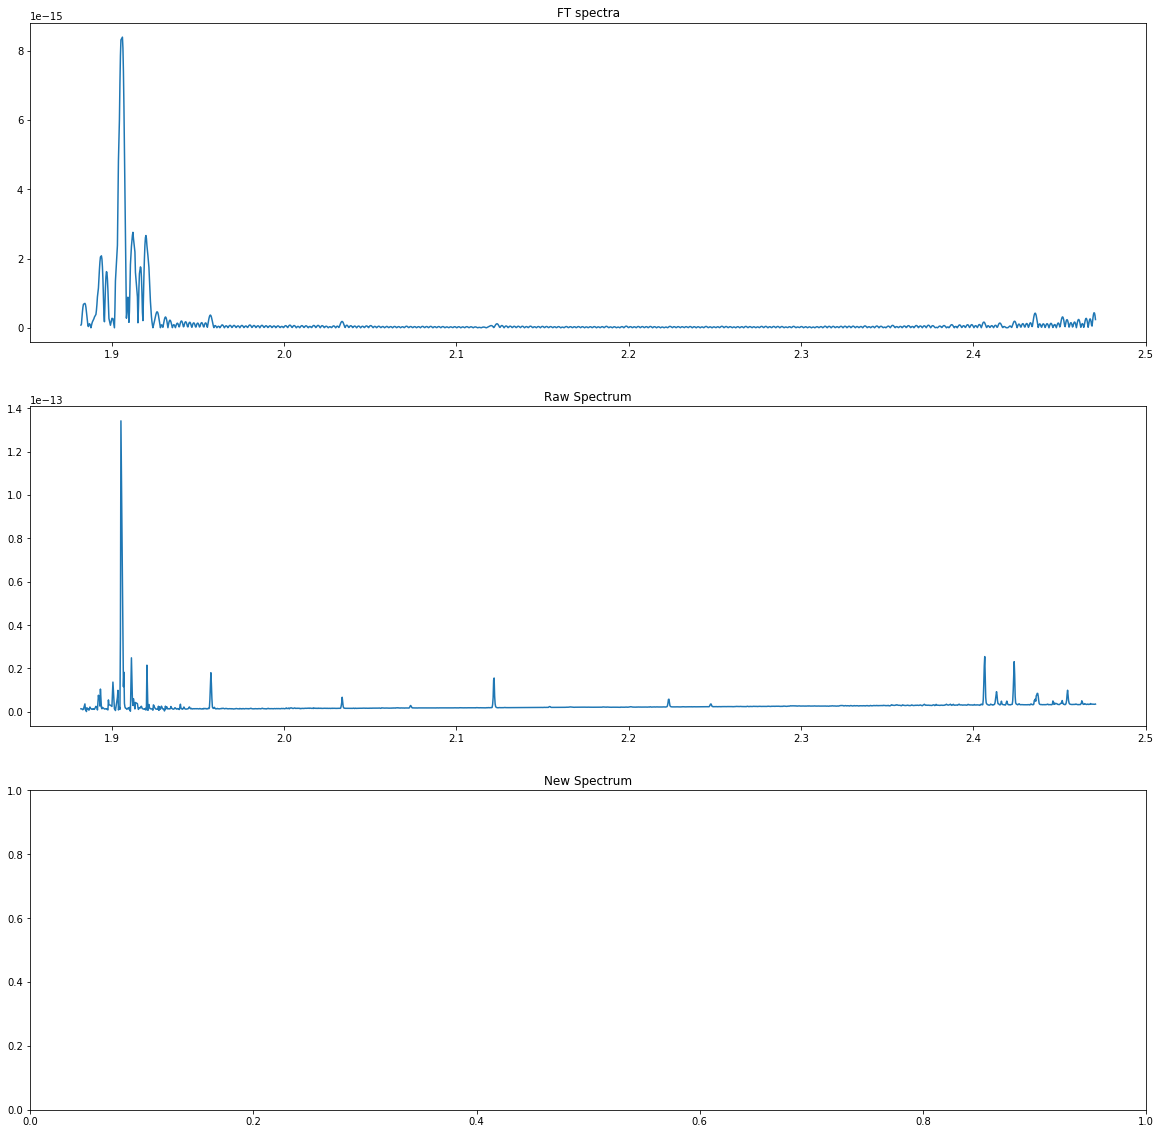

In [18]:
start=True
hdulist = fits.open(listoffiles)
for j in range(len(hdulist[0].data[:,0,:])):
    f,(ax1,ax2,ax3) = plt.subplots(1,3, figsize=[20,10],facecolor='w')
    lam = hdulist[0].data[j,0,:]
    flux = hdulist[0].data[j,1,:]
    mask =  np.where(flux > 0)
    lam = lam[mask]
    flux = flux[mask]
    i,x,k,y,F = fft(lam,flux)
    ax1.plot(i,F)
    ax1.set_title('FFT')
    ax2.plot(i,y)
    ax2.set_title('Power Spectrum')
    ax3.plot(i,k)
    ax3.set_title('Amplitude Spectrum')
    plt.draw()
    plt.tight_layout()
    plt.savefig(dire+'/'+source+'_order'+str(j+3)+'.fft.pdf',dpi=1000)
    plt.close()

continuum = {}
cuts=[1500,1500,200]
for j in range(len(hdulist[0].data[:,0,:])):    
    lam = hdulist[0].data[j,0,:]
    flux = hdulist[0].data[j,1,:]
    mask =  np.where(flux > 0)
    lam = lam[mask]
    flux = flux[mask]
    nlam,nflux = cut_fft(lam,flux, cuts[j],inverse=False)
    f,(ax1,ax2,ax3) = plt.subplots(3,1, figsize=[20,20],facecolor='w')
    ax1.set_title('FT spectra')
    ax1.plot(nlam,nflux)
    ax2.set_title('Raw Spectrum')
    ax2.plot(lam,flux)
    nmask = findLength(nlam)[-1]
    ax3.set_title('New Spectrum')
    cont = flux
    print(mask,nmask)
    fit = np.polyfit(lam[nmask],cont[nmask],2)
    fit_fn = np.poly1d(fit)
    ax3.plot(lam,fit_fn(lam),'r-')
    ax3.plot(lam,flux)
    temp ='{}o'.format(j)
    continuum[temp] = fit_fn
    ax3.plot([lam[nmask][0],lam[nmask][0]],[0,np.max(flux)],'r-')
    ax3.plot([lam[nmask][-1],lam[nmask][-1]],[0,np.max(flux)],'r-')
    ax3.set_ylim(ymin,ymax)
    plt.draw()
    plt.tight_layout()
    plt.savefig(dire+'/'+source+'_order'+str(j+3)+'.cut.pdf',dpi=1000)
    plt.close()
    count +=1

# Flatten

In [ ]:
xmin1 = 0.95
xmax1=1.8
xmin2 = 2.
xmax2=2.4
ymin = -0.5
start=False
ymax = 5
flat = {}

In [ ]:
# make sure you add statement for naming
plt.clf()
f,(ax1,ax2) = plt.subplots(1,2,sharey=True, figsize=[16,12],facecolor='w')
plt.text(1., 1.02, source,
         horizontalalignment='center',
         fontsize=15,
         transform = ax1.transAxes)

hdulist = fits.open(listoffiles)
for j in range(len(hdulist[0].data[:,0,:])):
    lam = hdulist[0].data[j,0,:]
    flux = hdulist[0].data[j,1,:]
    temp = '{}o'.format(j)
    flatten = continuum[temp]
    if j > 0:
        del1,del2 = plotting(ax1,xmin1,xmax1,lam,\
                flux,source+"_order"+str(j+3),listoflines,count=j,\
                              fitfn=flatten,start=start)
    else:
        del1,del2 = plotting(ax2,xmin2,xmax2,lam,\
                flux,source+"_order"+str(j+3),listoflines,count=j,\
                              fitfn=flatten,start=start)
    flat[temp] = [del1,del2]
plt.ylim(ymin,ymax)
plt.draw()
plt.savefig(dire+'/'+source+'_combined.flat.pdf',dpi=1000)
plt.close()

# Binning

In [ ]:
plt.clf()
f,(ax1,ax2) = plt.subplots(1,2,sharey=True, figsize=[16,12],facecolor='w')
plt.text(1., 1.02, source,
         horizontalalignment='center',
         fontsize=25,
         transform = ax1.transAxes)
count = 0

ax1.set_xlim(xmin1,xmax1)
ax2.set_xlim(xmin2,xmax2)
ax1.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax1.tick_params(labelright='off', labelsize = 25)
ax2.tick_params(labelsize = 25)
ax2.yaxis.tick_right()
ax1.set_ylabel(r"Relative Flux", fontsize = 20)
label = ax1.set_xlabel(r'Lambda ($\mu$m)', fontsize = 20)
ax1.xaxis.set_label_coords(1., -0.05)
plt.ylim(ymin,ymax)
hdulist = fits.open(listoffiles)
for j in range(len(hdulist[0].data[:,0,:])):   
    if j != orderlim:
        lam = binning(hdulist[0].data[j,0,:],5)
        flux = binning(hdulist[0].data[j,1,:],5)
        if j > 0:
            plotting2(ax1,xmin1,xmax1,lam,flux,source+"_order"+str(j+3),listoflines,count)
        else:
            plotting2(ax2,xmin2,xmax2,lam,flux,source+"_order"+str(j+3),listoflines,count)
    count +=1
        
d = .015 # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((1-d,1+d), (-d,+d), **kwargs)
ax1.plot((1-d,1+d),(1-d,1+d), **kwargs)

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d,+d), (1-d,1+d), **kwargs)
ax2.plot((-d,+d), (-d,+d), **kwargs)
ax2.plot((xmin2,xmin2),(-100,100),color='black',linewidth=5)

plt.subplots_adjust(wspace=0, hspace=0)
plt.draw()
ax1.legend(prop={'size': 15})
ax2.legend(prop={'size': 15})
plt.savefig(dire+'/'+source+'_combined.flat.binned.pdf',dpi=1000)
plt.close()

In [ ]:
import pickle
with open('rawdata.pickle','wb') as f:
    pickle.dump(raw,f)
with open('flatdata.pickle','wb') as f:
    pickle.dump(flat,f)